In [39]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer, MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("Clinical data/clinical_data.csv", index_col=0)

# Separate categorical and numerical
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(exclude=['object']).columns

# Impute missing values
df[cat_cols] = SimpleImputer(strategy="most_frequent").fit_transform(df[cat_cols])
df[num_cols] = SimpleImputer(strategy="mean").fit_transform(df[num_cols])

for col in cat_cols:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

# Combine and scale
scaler = MaxAbsScaler()

scaled = df.copy()
scaled[num_cols] = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols, index=df.index)
scaled

,histology_diagnosis,age,sex,race,participant_country,tumor_site,tumor_size_cm,tumor_necrosis,lymph_vascular_invasion,perineural_invasion,...,residual_tumor,tumor_stage_pathological,additiol_pathologic_findings,bmi,alcohol_consumption,tobacco_smoking_history,follow_up_days,vital_status,is_this_patient_lost_to_follow_up,cause_of_death
case_id,,,,,,,,,,,,,,,,,,,,,
C3L-00017,1,0.811765,1,1,11,2,0.600000,0,1,2,...,3,2,10,0.618809,0,0,0.312317,1,1,7
C3L-00102,1,0.494118,1,1,11,2,0.400000,0,2,2,...,0,4,2,0.587606,1,4,0.182551,0,0,7
C3L-00189,1,0.800000,0,1,1,2,0.360000,0,1,2,...,1,3,20,0.747982,0,1,0.758798,0,0,7
C3L-00277,1,0.811765,1,1,6,4,0.666667,0,1,2,...,2,3,6,0.523674,0,4,0.447214,0,1,7
C3L-00401,1,0.729412,0,1,1,0,0.373333,0,2,2,...,0,3,1,0.489199,0,4,0.900293,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C3N-04119,1,0.635294,1,1,2,4,0.400000,0,1,2,...,0,3,2,0.516256,4,4,0.223607,0,0,7
C3N-04126,1,0.494118,1,1,2,2,0.466667,0,2,2,...,0,4,2,0.531966,4,4,0.255132,0,0,7
C3N-04282,1,0.882353,1,1,7,2,0.533333,1,2,2,...,1,5,20,0.349116,0,3,0.222141,0,0,7


In [40]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering

scores = []
for k in range(2, 10):
    spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors',
                                  assign_labels='kmeans', random_state=42)
    labels = spectral.fit_predict(scaled)
    score = silhouette_score(scaled, labels)
    scores.append((k, score))

print(scores)

[(2, 0.13776885544053386), (3, 0.3571712652143481), (4, 0.31091865644366223), (5, 0.25470526537516863), (6, 0.27254210615858654), (7, 0.22607118281339542), (8, 0.228958816686424), (9, 0.22519973813489516)]


In [41]:
from sklearn.cluster import SpectralClustering

n_clusters = 3
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0)
labels = spectral.fit_predict(scaled)

In [42]:
scaled['cluster'] = labels
summary = scaled.groupby('cluster').agg(['mean', 'std', 'count'])
summary

histology_diagnosis                       age                  \
                       mean       std count      mean       std count   
cluster                                                                 
0                  0.971831  0.166633    71  0.762220  0.124091    71   
1                  0.968750  0.176777    32  0.803676  0.091199    32   
2                  0.945946  0.229243    37  0.702385  0.154339    37   

              sex                      race  ... follow_up_days vital_status  \
             mean       std count      mean  ...          count         mean   
cluster                                      ...                               
0        0.535211  0.502309    71  0.971831  ...             71     0.380282   
1        0.531250  0.507007    32  1.000000  ...             32     0.468750   
2        0.513514  0.506712    37  1.000000  ...             37     0.459459   

                        is_this_patient_lost_to_follow_up                  \
              std count                              mean       std count   
cluster                                                                     
0        0.488911    71                          0.338028  0.476405    71   
1        0.507007    32                          0.375000  0.491869    32   
2        0.505228    37                          0.216216  0.417342    37   

        cause_of_death                  
                  mean       std count  
cluster                                 
0             6.647887  1.484189    71  
1             6.687500  1.533234    32  
2             7.216216  0.583816    37  

[3 rows x 72 columns]

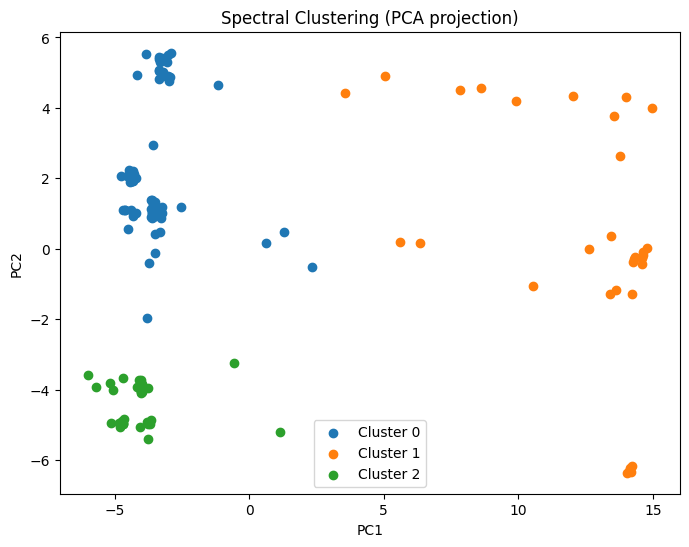

In [43]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled.drop(columns=['cluster']))

plt.figure(figsize=(8,6))
for i in range(n_clusters):
    plt.scatter(reduced[labels==i,0], reduced[labels==i,1], label=f"Cluster {i}")
plt.legend()
plt.title("Spectral Clustering (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


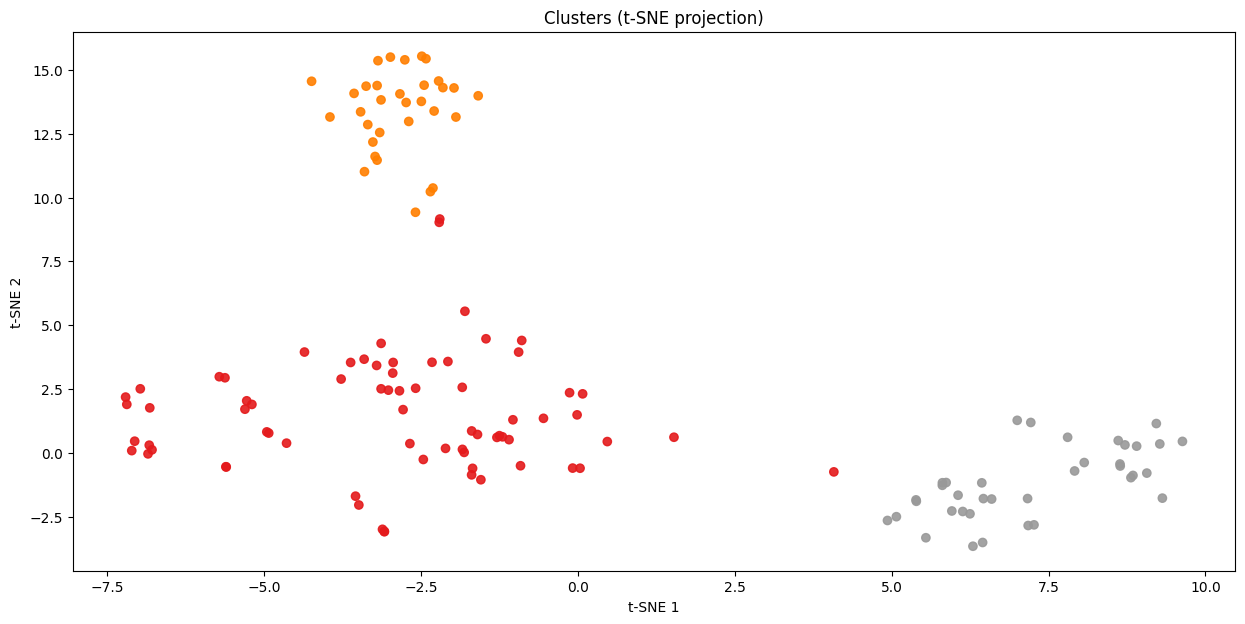

In [44]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(scaled.drop(columns=['cluster'])) 

plt.figure(figsize=(15,7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1', alpha=0.9)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Clusters (t-SNE projection)')

plt.savefig(r'images/t-SNE.png', transparent=True, bbox_inches='tight')